Network Analysis of Vaccination Strategies  
Copyright (C) 2020 by The RAND Corporation  
See LICENSE.txt and README.txt for information on usage and licensing

# SEIR Model Notebook

We will consider a Markovian SEIR model on the contact networks. The transitions are:
- $S \rightarrow E$ occurs at a rate $\beta$, which will be calibrated to produce a doubling period of 3 days in a pre-social distancing setting
- $E \rightarrow I$ occurs at an inverse rate $a^{-1} = 3$ days 
- $I \rightarrow R$ occurs at a rate $\gamma^{-1} = 14$ days

We will also incorporate the contact time between nodes. This is represented by the weight $w_{ij}$ of an edge $(i,j)$. How should the edge weight affect the transmission probability? The simplest approach, and the one which we will adopt, is to simply rescale the transmission rate by the edge weights, i.e. $\beta_{ij} = w_{ij} \beta$. The transmission probability then becomes $p(\beta_{ij}) = 1 - e^{-w_{ij} \beta D}$. 

In [1]:
import collections, os, pickle
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import random, scipy
from tqdm.notebook import tqdm

from utils import *
import EoN

import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

plt.style.use('figures/theme_bw.mplstyle')
%matplotlib inline

fontsize = 16
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

colormap = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
## load the contact networks
#G_pre = nx.read_gpickle("data/G_pre.gpickle")
#G_post = nx.read_gpickle("data/G_post.gpickle")

G_pre = nx.read_weighted_edgelist("data/G_pre.adjlist", nodetype=float)
G_post = nx.read_weighted_edgelist("data/G_post.adjlist", nodetype=float)

## get the number of nodes in each graph
N_pre = G_pre.number_of_nodes()
N_post = G_post.number_of_nodes()
N_dict = {'pre':N_pre, 'post':N_post}
N_dict

{'pre': 214393, 'post': 130910}

The edge weights are in units of days (see the function `graph_from_edge_list` in utils.py)

In [3]:
edges_pre = list(G_pre.edges())
edges_pre[0]

(2979831.0, 3202377.0)

In [4]:
G_pre

In [5]:
G_pre[edges_pre[1][0]][edges_pre[1][1]]["weight"]

0.0016550925925925926

In this notebook we will implement vaccination by removing vaccinated nodes from the graph.

In [6]:
def vaccination_uniform(G, f):
    '''
    Remove a fraction f of nodes from a graph G. 
    The nodes will be removed uniformly at random,
    corresponding to an untargeted vaccination strategy.
    '''
    G = G.copy()
    Ndelete = int(f * G.number_of_nodes())
    delete_nodes = np.random.choice(list(G.nodes()), size=Ndelete, replace=False)
    for node in delete_nodes:
            G.remove_node(node)
    return G


def vaccination_targeted(G, f):
    '''
    Remove the f*N highest degree nodes, corresponding 
    to a targeted vaccination strategy.
    '''
    G = G.copy()
    Ndelete = int(f * G.number_of_nodes())
    delete_nodes = np.asarray(sorted(G.degree, key=lambda x: x[1], reverse=True))[:Ndelete,0]
    for node in delete_nodes:
            G.remove_node(node)
    return G

Build a wrapper function that builds the SEIR model for a given network, applies the vaccination strategy, and then evaluates the model for multiple runs.

In [7]:
def initial_nodes(G):
    '''initial nodes to seed the pandemic with'''
    ## infect a single degree-50 node (or next best degree)
    return [degree_getter_improved(G, 50)]

In [8]:
def run_model(iterations, beta, socialdist='pre', vacc='none', vacc_f=0, tmax=float('Inf'), verbose=False):
    '''
    Run the model with the specified parameters and record the parameters and results in a dict.
    Note: EoN is capable of returning a more detailed record of results by passing in return_full_results=True
    to the Gillespie_simple_contagion method, but the data object is about 7 times as large.
    '''
    
    ## define the SEIR model dynamics
    spontaneous_transition_graph = nx.DiGraph()
    spontaneous_transition_graph.add_node('S')
    spontaneous_transition_graph.add_edge('E', 'I', rate = 1/3)
    spontaneous_transition_graph.add_edge('I', 'R', rate = 1/14)

    nbr_induced_transition_graph = nx.DiGraph()
    nbr_induced_transition_graph.add_edge(('I', 'S'), ('I', 'E'), rate = beta, weight_label='weight')
    
    return_statuses = ('S', 'E', 'I', 'R')

    ## pre or post social distancing
    if socialdist == 'pre':
        G = G_pre
    elif socialdist == 'post':
        G = G_post
    else:
        print('Error! Network not recognized.')
    
    ## vaccination
    if vacc == 'targeted':
        G = vaccination_targeted(G, vacc_f)
    elif vacc == 'uniform':
        G = vaccination_uniform(G, vacc_f)

    ## relabel the nodes
    G = nx.convert_node_labels_to_integers(G)
    
    ## run the simulations
    tlist = []
    Slist = []
    Elist = []
    Ilist = []
    Rlist = []
    for i in range(iterations):

        ## initial conditions
        initial_condition = collections.defaultdict(lambda: 'S')
        init_nodes = initial_nodes(G)
        for node in init_nodes:
            initial_condition[node] = 'I'

        ## Note: some runs will have the pandemic die out before it catches        
        t, S, E, I, R = EoN.Gillespie_simple_contagion(G, 
                                           spontaneous_transition_graph, 
                                           nbr_induced_transition_graph, 
                                           initial_condition, 
                                           return_statuses,
                                           #return_full_data=True,
                                           tmax = tmax)

        tlist.append(t)
        Slist.append(S)
        Elist.append(E)
        Ilist.append(I)
        Rlist.append(R)
        
    model_dict = {'socialdist':socialdist,
                  'vacc':vacc,
                  'vacc_f':vacc_f,
                  'iterations':iterations,
                  'beta':beta,
                  't':tlist,
                  'S':Slist,
                  'E':Elist,
                  'I':Ilist,
                  'R':Rlist
                 }
    
    ## clear G, if that helps at all
    G = None
    
    return model_dict

Do an example run:

In [9]:
result = run_model(iterations=3, beta=5, socialdist='post', vacc='none', vacc_f=0, verbose=True)

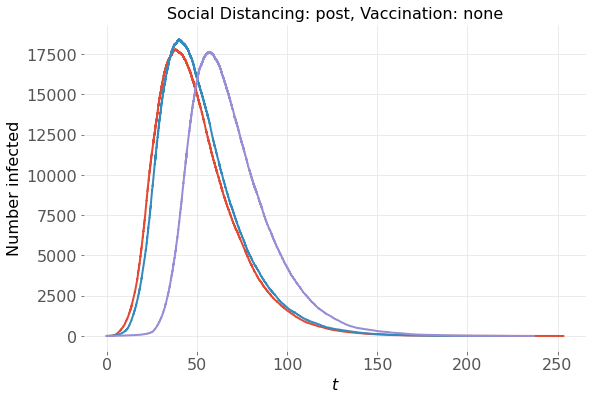

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
for i in range(3):
    ax.plot(result['t'][i], result['I'][i], lw=2)
ax.set_xlabel('$t$')
ax.set_ylabel('Number infected')
plt.title('Social Distancing: %s, Vaccination: %s' %(result['socialdist'], result['vacc']))
plt.show()

### Model Calibration

Calibrate the model by selecting the transmission rate $\beta$ such that it takes 14 days for the disease to go from 50 to 500 infected.

In [11]:
def calc_Delta_T(beta, G):
    '''given a beta value, find the time for the disease to go from 50 to 500 infecteds'''

    ## define the SEIR model dynamics
    spontaneous_transition_graph = nx.DiGraph()
    spontaneous_transition_graph.add_node('S')
    spontaneous_transition_graph.add_edge('E', 'I', rate = 1/3)
    spontaneous_transition_graph.add_edge('I', 'R', rate = 1/14)

    nbr_induced_transition_graph = nx.DiGraph()
    nbr_induced_transition_graph.add_edge(('I', 'S'), ('I', 'E'), rate = beta, weight_label='weight')
    
    return_statuses = ('S', 'E', 'I', 'R')    
    
    initial_condition = collections.defaultdict(lambda: 'S')
    init_nodes = initial_nodes(G)
    for node in init_nodes:
        initial_condition[node] = 'I'
    
    t, S, E, I, R = EoN.Gillespie_simple_contagion(G, 
                                   spontaneous_transition_graph, 
                                   nbr_induced_transition_graph,
                                   initial_condition, 
                                   return_statuses,
                                   tmax=100)
    
    ## in some runs the pandemic doesn't take off
    try:
        t50 = t[np.argwhere(I >= 50)[0]]
        t500 = t[np.argwhere(I >= 500)[0]]
        return (t500 - t50)[0]
    except:
        return None

In [12]:
calc_Delta_T(5, G_post)

7.0568899780864225

In [13]:
beta = 1.5
iterations = 100

In [14]:
betalist = []
Delta_T_list = []

cond = True
while cond:
    
    ## consider different runs for a given beta0 to account for the variability
    Delta_T = [calc_Delta_T(beta, G_post) for i in range(iterations)]

    ## remove the failed runs
    num_failed = np.sum([i == None for i in Delta_T])
    Delta_T = [t for t in Delta_T if t != None]

    ## take an average
    if len(Delta_T) >= 1:
        Delta_T = np.mean(Delta_T)
    else:
        Delta_T = -1 
        
    ## assuming none of the calibration runs failed, adjust beta0
    if Delta_T != -1:
        ## record result
        Delta_T_list.append(Delta_T)
        print('beta = %.3f, Delta T = %.3f, Failed Runs = %i' %(beta, Delta_T, num_failed))

        ## adjust tau
        if Delta_T > 15:
            beta = 1.1*beta
        elif Delta_T < 13:
            beta = 0.9*beta
        
        cond = not (13 < Delta_T and Delta_T < 15)
        
print('beta = ', beta)
np.save('data/SEIR/beta', beta)

beta = 1.500, Delta T = 12.473, Failed Runs = 31
beta = 1.350, Delta T = 12.680, Failed Runs = 25
beta = 1.215, Delta T = 15.808, Failed Runs = 22
beta = 1.337, Delta T = 13.207, Failed Runs = 14
beta =  1.3365000000000002


## Example Run

**Averaging the results of many runs**

The motivation for using more than 1 iteration is to average the results of many simulations. We would like to make plots showing the average of many runs, plus error bars/confidence intervals showing the expected deviation from the mean in any one run. The issue is that the (smart) way the EoN package simulates temporal events means that the timesteps are different in each run. So we cannot simply average any of the S, E, I, R result arrays. 

To deal with this, I'll first find an interpolating function, and then average the results of the interpolation evaluated at the same sequence of times for each simulation run.

**Note** This doesn't work if some of the runs die out quickly

In [15]:
tlist = []
Ilist = []
Rlist = []
for i in range(len(result['t'])):
    if len(result['t'][i]) > 1000:
        tlist.append(result['t'][i])
        Ilist.append(result['I'][i])
        Rlist.append(result['R'][i])

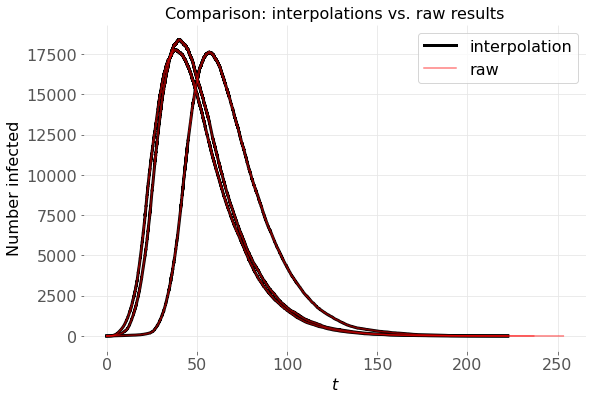

In [16]:
t_int, results_int = interpolation(tlist, Ilist)

fig, ax = plt.subplots(figsize=(9,6))

for i in range(len(results_int)):
    if i == 0:
        ax.plot(t_int, results_int[i], color='k', alpha=1, linestyle='-', linewidth=3, label='interpolation')
    else:
        ax.plot(t_int, results_int[i], color='k', alpha=1, linestyle='-', linewidth=3)

for i in range(len(results_int)):
    if i == 0:
        ax.plot(result['t'][i], result['I'][i], color='r', alpha=0.5, label='raw')
    else:
        ax.plot(result['t'][i], result['I'][i], color='r', alpha=0.5)
        
ax.set_title('Comparison: interpolations vs. raw results')
ax.set_xlabel('$t$')
ax.set_ylabel('Number infected')

#ax.set_xlim([20, 25])
#ax.set_ylim([5000, 30000])

ax.legend()
plt.show()

Use the interpolation to plot the mean and confidence intervals.

In [17]:
mean, under, uppper = mean_confidence_interval(results_int)

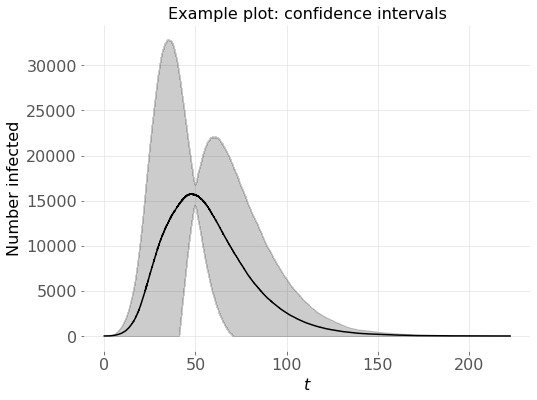

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(t_int, mean, color='k')
ax.fill_between(t_int, under, uppper, color='k', alpha=0.2)
ax.set_title('Example plot: confidence intervals')
ax.set_xlabel('$t$')
ax.set_ylabel('Number infected')

plt.show()

Analyze the peak infected and total number infected:

In [19]:
print('avg. peak infected: %.2f' % np.mean([np.max(Ilist[i]) for i in range(len(Ilist))]))
print('avg. peak infected (fraction): %.2f' % np.mean([np.max(Ilist[i])/G_pre.number_of_nodes() for i in range(len(Ilist))]))

print('avg. total infected: %.2f' % np.mean([Rlist[i][-1] for i in range(len(Ilist))]))
print('avg. total infected (fraction): %.2f' % np.mean([Rlist[i][-1]/G_pre.number_of_nodes() for i in range(len(Ilist))]))

avg. peak infected: 17941.67
avg. peak infected (fraction): 0.08
avg. total infected: 59527.67
avg. total infected (fraction): 0.28


## Scan over vaccination fraction $f$

In [20]:
beta

1.3365000000000002

First, consider the same small set of vaccination fractions for each strategy so that we can directly compare them.

In [21]:
tmax = np.inf
socialdistlist = ['pre', 'post']
vacclist = ['none', 'uniform', 'targeted']
flist = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]

In [22]:
## loop over scenarios
for socialdist in socialdistlist:
    
    print('socialdist = %s' %socialdist)
    
    for vacc in vacclist:

        ## no vaccination
        if vacc == 'none':
            print('vaccination = %s' %vacc)
            name = socialdist + '_' + vacc
            result = run_model(iterations=iterations, 
                               beta=beta, 
                               socialdist=socialdist, 
                               vacc=vacc, 
                               vacc_f=0,
                               tmax=tmax)
            
            ## save
            with open('data/SEIR/results_' + name + '.txt', 'wb') as file:
                pickle.dump(result, file)            

        ## vaccination: scan over f
        else:
                
            print('vaccination = %s' %vacc)
            for i in tqdm(range(len(flist))):
                name = socialdist + '_' + vacc + '_' + str(flist[i])                
                result  = run_model(iterations=iterations, 
                                   beta=beta, 
                                   socialdist=socialdist, 
                                   vacc=vacc, 
                                   vacc_f=flist[i],
                                   tmax=tmax)

                ## save
                with open('data/SEIR/results_' + name + '.txt', 'wb') as file:
                    pickle.dump(result, file)

socialdist = pre
vaccination = none
vaccination = uniform


  0%|          | 0/6 [00:00<?, ?it/s]

vaccination = targeted


  0%|          | 0/6 [00:00<?, ?it/s]

socialdist = post
vaccination = none
vaccination = uniform


  0%|          | 0/6 [00:00<?, ?it/s]

vaccination = targeted


  0%|          | 0/6 [00:00<?, ?it/s]

Next, use a different range of f values for each strategy.

In [23]:
flist_pre_uniform = np.linspace(0.01, 0.9, 40)
flist_post_uniform = np.linspace(0.01, 0.6, 40)
flist_pre_targeted = np.linspace(0.01, 0.3, 40)
flist_post_targeted = np.linspace(0.001, 0.05, 40)

np.save('data/SEIR/flist_pre_uniform', flist_pre_uniform)
np.save('data/SEIR/flist_pre_targeted', flist_pre_targeted)
np.save('data/SEIR/flist_post_uniform', flist_post_uniform)
np.save('data/SEIR/flist_post_targeted', flist_post_targeted)

In [24]:
tmax = np.inf
socialdistlist = ['pre', 'post']
vacclist = ['uniform', 'targeted']

## loop over scenarios
for socialdist in socialdistlist:
    
    print('socialdist = %s' %socialdist)
    
    for vacc in vacclist:

        ## no vaccination
        if vacc == 'none':
            print('vaccination = %s' %vacc)
            name = socialdist + '_' + vacc
            result = run_model(iterations=iterations, 
                               beta=beta, 
                               socialdist=socialdist, 
                               vacc=vacc, 
                               vacc_f=0,
                               tmax=tmax)
             
            ## save
            with open('data/SEIR/results_' + name + '.txt', 'wb') as file:
                pickle.dump(result, file)            

        ## vaccination: scan over f
        else:
            
            if vacc == 'uniform' and socialdist == 'pre':
                flist = flist_pre_uniform
            elif vacc == 'targeted' and socialdist == 'pre':
                flist = flist_pre_targeted
            elif vacc == 'uniform' and socialdist == 'post':
                flist = flist_post_uniform
            elif vacc == 'targeted' and socialdist == 'post':
                flist = flist_post_targeted
                
            print('vaccination = %s' %vacc)
            for i in tqdm(range(len(flist))):
                name = socialdist + '_' + vacc + '_' + str(flist[i])         
                result  = run_model(iterations=iterations, 
                                   beta=beta, 
                                   socialdist=socialdist, 
                                   vacc=vacc, 
                                   vacc_f=flist[i],
                                   tmax=tmax)

                ## save
                with open('data/SEIR/results_' + name + '.txt', 'wb') as file:
                    pickle.dump(result, file)

socialdist = pre
vaccination = uniform


  0%|          | 0/40 [00:00<?, ?it/s]

vaccination = targeted


  0%|          | 0/40 [00:00<?, ?it/s]

socialdist = post
vaccination = uniform


  0%|          | 0/40 [00:00<?, ?it/s]

vaccination = targeted


  0%|          | 0/40 [00:00<?, ?it/s]